In [1]:
import sys
sys.path.append('../utils/bbox')

import os
from pathlib import Path
import glob

import cv2
import numpy as np
import numpy.matlib as npm
import scipy as sp
import scipy.spatial as sps
from scipy.ndimage import center_of_mass
import scipy.ndimage
from scipy import spatial

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import rcParams
from matplotlib.patches import Polygon
import seaborn as sns

from PIL import Image, ImageDraw
import math
import pickle as pk

from bbox.min_bounding_rect import minBoundingRect

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
#Load the data
hd_r1 = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/melting/r1/hail_sizes/hail_dict.pkl'
hd_r2 = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/melting/r2/hail_sizes/hail_dict.pkl'
hd_r3 = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/melting/r3/hail_sizes/hail_dict.pkl'
hd_r4 = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/melting/r4/hail_sizes/hail_dict.pkl'
hd_r5 = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/melting/r5/hail_sizes/hail_dict.pkl'

with open(hd_r1,'rb') as f:
    dict_r1 = pk.load(f)

with open(hd_r2,'rb') as f:
    dict_r2 = pk.load(f)
    
with open(hd_r3,'rb') as f:
    dict_r3 = pk.load(f)

with open(hd_r4,'rb') as f:
    dict_r4 = pk.load(f)

with open(hd_r5,'rb') as f:
    dict_r5 = pk.load(f)
   
ndict = {}
ndict['0'] = dict_r1
ndict['1'] = dict_r2
ndict['2'] = dict_r3
ndict['3'] = dict_r4
ndict['4'] = dict_r5

In [ ]:
#ToDo
#Investigate melting rate according REF 2 comment 

In [3]:
ma1 = np.asarray(ndict['0']['major_ma'])
ma2 = np.asarray(ndict['1']['major_ma'])
ma3 = np.asarray(ndict['2']['major_ma'])
ma4 = np.asarray(ndict['3']['major_ma'])
ma5 = np.asarray(ndict['4']['major_ma'])

mi1 = np.asarray(ndict['0']['minor_ma'])
mi2 = np.asarray(ndict['1']['minor_ma'])
mi3 = np.asarray(ndict['2']['minor_ma'])
mi4 = np.asarray(ndict['3']['minor_ma'])
mi5 = np.asarray(ndict['4']['minor_ma'])

ar1 = mi1 / ma1
ar2 = mi2 / ma2
ar3 = mi3 / ma3
ar4 = mi4 / ma4
ar5 = mi5 / ma5

ar=np.asarray([ar1,ar2,ar3,ar4,ar5],dtype=object)

In [13]:
ar[0]

array([1.        , 1.        , 1.        , ..., 0.66666667, 0.75      ,
       1.        ])

Text(0.5, 0, 'Major axis [mm]')

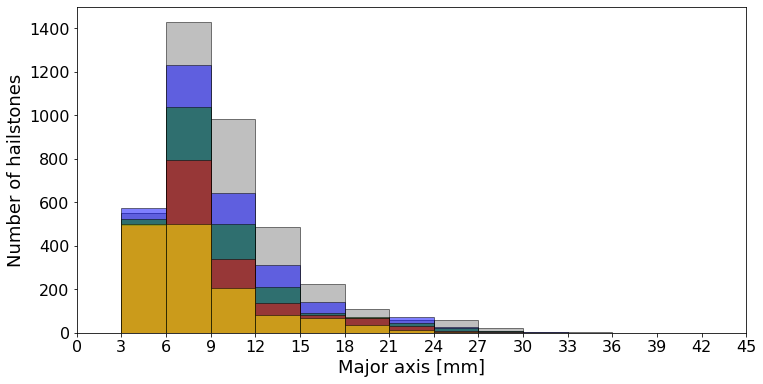

In [4]:
fig, ax = plt.subplots(figsize=[12,6])
fig.patch.set_facecolor('white')
numBins = 14+4
den=False
c1, e1, b1 = ax.hist([ma1],numBins,range=[3,45+12],density=den,color=['grey'],alpha=0.5, edgecolor='black',label='Flight 1')
c2, e2, b2 = ax.hist([ma2],numBins,range=[3,45+12],density=den,color=['blue'],alpha=0.5, edgecolor='black',label='Flight 2')
c3, e3, b3 = ax.hist([ma3],numBins,range=[3,45+12],density=den,color=['green'],alpha=0.5, edgecolor='black',label='Flight 3')
c4, e4, b4 = ax.hist([ma4],numBins,range=[3,45+12],density=den,color=['red'],alpha=0.5, edgecolor='black',label='Flight 4')
c5, e5, b5 = ax.hist([ma5],numBins,range=[3,45+12],density=den,color=['yellow'],alpha=0.5, edgecolor='black',label='Flight 5')

#ax.set_ylim([0.9,1500])
ax.set_xlim([0,45])
ax.set_yscale('linear')
ax.set_xticks(np.linspace(0,39+6,14+2))
ax.set_ylabel('Number of hailstones')
ax.set_xlabel('Major axis [mm]')


In [12]:
def func(x):
    y = np.sum(x)
    return y

ind = np.digitize(ma1, e1)
result = [func(ma1[ind == j]) for j in range(1, numBins)]

In [4]:
numBins = 14+4
r1 = scipy.stats.binned_statistic(ma1, ma1, statistic='count', bins=numBins, range=[3,45+12])
r2 = scipy.stats.binned_statistic(ma2, ma2, statistic='count', bins=numBins, range=[3,45+12])
r3 = scipy.stats.binned_statistic(ma3, ma3, statistic='count', bins=numBins, range=[3,45+12])
r4 = scipy.stats.binned_statistic(ma4, ma4, statistic='count', bins=numBins, range=[3,45+12])
r5 = scipy.stats.binned_statistic(ma5, ma5, statistic='count', bins=numBins, range=[3,45+12])

ind1 = {}
for j in range(1,12):
    ind1[j] = np.where(r1.binnumber == j)
    
ind2 = {}
for j in range(1,12):
    ind2[j] = np.where(r2.binnumber == j)
    
ind3 = {}
for j in range(1,12):
    ind3[j] = np.where(r3.binnumber == j)

ind4 = {}
for j in range(1,12):
    ind4[j] = np.where(r4.binnumber == j)
    
ind5 = {}
for j in range(1,12):
    ind5[j] = np.where(r5.binnumber == j)

indall = np.array([ind1,ind2,ind3,ind4,ind5],dtype=object)    

In [19]:
#Only two bins > 20mm, < 20mm 
numBins = 2
r1 = scipy.stats.binned_statistic(ma1, ma1, statistic='count', bins=numBins, range=[0,40])
r2 = scipy.stats.binned_statistic(ma2, ma2, statistic='count', bins=numBins, range=[0,40])
r3 = scipy.stats.binned_statistic(ma3, ma3, statistic='count', bins=numBins, range=[0,40])
r4 = scipy.stats.binned_statistic(ma4, ma4, statistic='count', bins=numBins, range=[0,40])
r5 = scipy.stats.binned_statistic(ma5, ma5, statistic='count', bins=numBins, range=[0,40])

ind1 = {}
for j in range(1,3):
    ind1[j] = np.where(r1.binnumber == j)
    
ind2 = {}
for j in range(1,3):
    ind2[j] = np.where(r2.binnumber == j)
    
ind3 = {}
for j in range(1,3):
    ind3[j] = np.where(r3.binnumber == j)

ind4 = {}
for j in range(1,3):
    ind4[j] = np.where(r4.binnumber == j)
    
ind5 = {}
for j in range(1,3):
    ind5[j] = np.where(r5.binnumber == j)

indall = np.array([ind1,ind2,ind3,ind4,ind5],dtype=object)

In [15]:
ind1

{1: (array([   0,    1,    2, ..., 3922, 3923, 3924]),),
 2: (array([  41,   54,  113,  120,  144,  199,  226,  237,  244,  263,  272,
          296,  347,  398,  413,  441,  451,  452,  467,  510,  530,  532,
          540,  549,  731,  781,  791,  811,  850,  856,  888,  889,  937,
          971, 1026, 1030, 1059, 1060, 1061, 1072, 1084, 1095, 1108, 1155,
         1179, 1221, 1269, 1294, 1308, 1397, 1429, 1464, 1530, 1571, 1603,
         1610, 1615, 1649, 1662, 1693, 1705, 1798, 1857, 1865, 1868, 1890,
         1898, 1900, 1909, 1926, 1971, 1973, 1975, 2024, 2052, 2064, 2083,
         2085, 2105, 2127, 2142, 2171, 2175, 2176, 2179, 2195, 2254, 2265,
         2296, 2333, 2340, 2348, 2420, 2442, 2447, 2482, 2497, 2570, 2591,
         2611, 2638, 2639, 2684, 2692, 2728, 2746, 2779, 2781, 2806, 2864,
         2935, 2959, 2960, 3018, 3098, 3105, 3144, 3164, 3175, 3185, 3202,
         3456, 3464, 3465, 3495, 3529, 3555, 3643, 3662, 3663, 3676, 3679,
         3688, 3730, 3736, 3739, 3781, 3

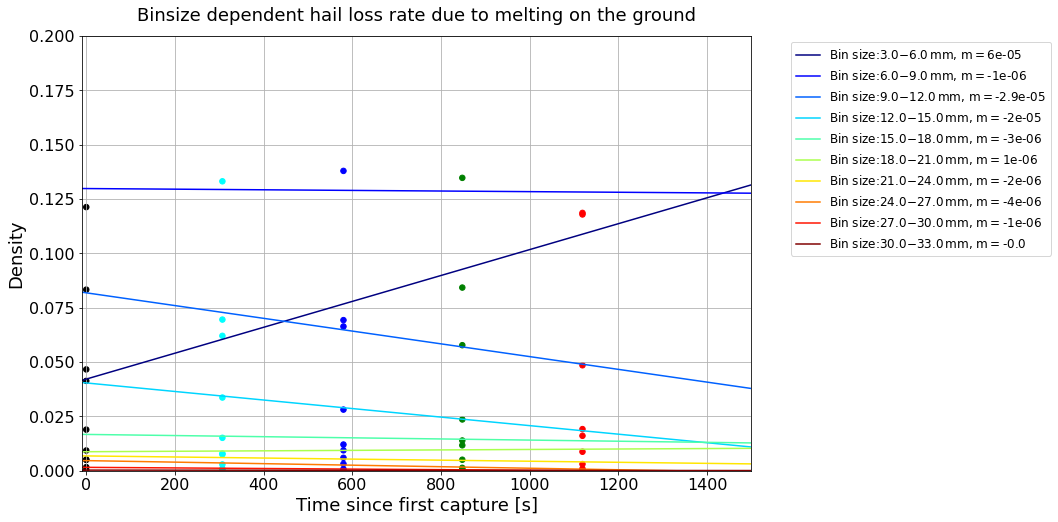

In [16]:
from scipy.stats import linregress
x=np.array([0,307,580,848,1119])
cols = ['black','cyan','blue','green','red']
#cols1 = ['0','0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.7','0.7']
cols1 = plt.cm.jet(np.linspace(0,1,10))

y=[]
for i in range(0,10):
    y.append(np.array([c1[i], c2[i],c3[i],c4[i],c5[i]]))


fig, ax = plt.subplots(figsize=[12,8])
fig.patch.set_facecolor('white')

for n,v in enumerate(y):
    m, b, *_ = linregress(x, v)
    ax.scatter(x,v,s=30,c=cols)
    l1 = ax.axline(xy1=(0, b), slope=m, color=cols1[n], label='Bin size:'+str(e1[n])+'$-$'+str(e1[n+1])+'$\,$mm, m$=$'+str(round(m,6)))

ax.set_xlabel('Time since first capture [s]')
ax.set_ylabel('Density')
ax.set_title('Binsize dependent hail loss rate due to melting on the ground',fontsize=18,pad=15)
ax.legend(fontsize=12,bbox_to_anchor=(1.05, 1.0), loc='upper left')
ax.set_xlim([-10,1500])
ax.set_ylim([0,0.2])
ax.grid()

In [23]:
cols1

array([[0.        , 0.        , 0.85650624, 1.        ]])

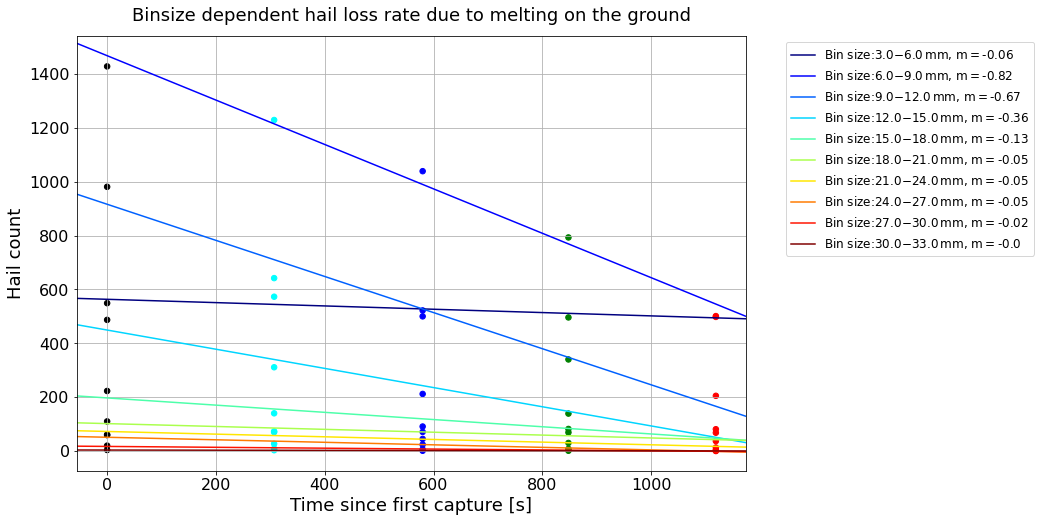

In [5]:
from scipy.stats import linregress
x=np.array([0,307,580,848,1119])
cols = ['black','cyan','blue','green','red']
cols1 = plt.cm.jet(np.linspace(0,1,10))

hloss = [848,566,549,551]

y=[]
for i in range(0,10):
    y.append(np.array([c1[i], c2[i],c3[i],c4[i],c5[i]]))

fig, ax = plt.subplots(figsize=[12,8])
fig.patch.set_facecolor('white')

for n,v in enumerate(y):
    m, b, *_ = linregress(x, v)
    ax.scatter(x,v,s=30,c=cols)
    l1 = ax.axline(xy1=(0, b), slope=m, color=cols1[n], label='Bin size:'+str(e1[n])+'$-$'+str(e1[n+1])+'$\,$mm, m$=$'+str(round(m,2)))

ax.set_xlabel('Time since first capture [s]')
ax.set_ylabel('Hail count')
ax.set_title('Binsize dependent hail loss rate due to melting on the ground',fontsize=18,pad=15)
ax.legend(fontsize=12, bbox_to_anchor=(1.05, 1.0), loc='upper left')
#ax.set_xlim([-10,1200])
ax.grid()
plt.savefig('Hail_loss_rate.png',dpi=400,bbox_inches='tight',facecolor='white')

In [6]:
y

[array([549., 573., 522., 496., 501.]),
 array([1428., 1229., 1039.,  793.,  498.]),
 array([981., 642., 500., 340., 205.]),
 array([487., 311., 212., 139.,  81.]),
 array([223., 140.,  91.,  82.,  68.]),
 array([110.,  70.,  71.,  69.,  37.]),
 array([61., 73., 45., 30., 13.]),
 array([59., 27., 24.,  8.,  4.]),
 array([20.,  9.,  6.,  4.,  0.]),
 array([4., 3., 1., 1., 1.])]

In [14]:
#hloss = [848,566,549,551]
ynew = np.array([[549,199],
                 [1129,1030],
                 [882,642],
                 [247,311],
                 [223,140],
                 [61,-2],
                 [59,25],
                 [20,7],
                 [0,1],
                 [0,1]])

In [9]:
#Annahme - Hagel wechselt nur zum nächstkleineren BIN zwischen den 5 Flügen
hloss = [848,566,549,551]
z = y
#for i,loss in enumerate(hloss):
for k in range(0,10):    
    tmp = y[0][1] - hloss[0]
    
    z[k+1][1] =  y[k+1][1] + tmp
    
    break


In [10]:
z

[array([549., 573., 522., 496., 501.]),
 array([1428.,  954., 1039.,  793.,  498.]),
 array([981., 642., 500., 340., 205.]),
 array([487., 311., 212., 139.,  81.]),
 array([223., 140.,  91.,  82.,  68.]),
 array([110.,  70.,  71.,  69.,  37.]),
 array([61., 73., 45., 30., 13.]),
 array([59., 27., 24.,  8.,  4.]),
 array([20.,  9.,  6.,  4.,  0.]),
 array([4., 3., 1., 1., 1.])]

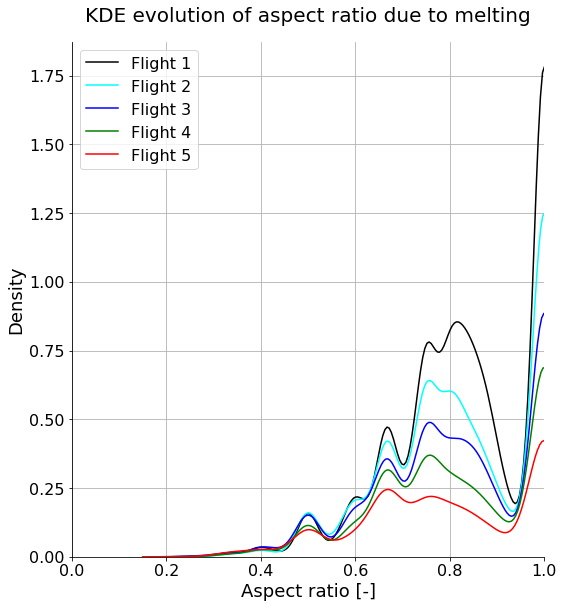

In [39]:
#Look if hail the stone projections become more spherical with melting time
plot_dir = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/plots/melting/'
pal = ['black','cyan','blue','green','red']
pal.reverse()
test = sns.displot(data=[ar5, ar4, ar3, ar2, ar1], kind="kde", bw_adjust=0.8, fill=False, legend=False, palette=pal,height=8,aspect=8/8)

plt.xlabel('Aspect ratio [-]')
plt.legend(labels=['Flight 1','Flight 2','Flight 3','Flight 4','Flight 5'],loc='upper left')
plt.title('KDE evolution of aspect ratio due to melting',fontsize=20,pad=20)
plt.xlim([0,1])
plt.grid()
plt.savefig('KDE_aspect_ratio_melting.png',dpi=400,bbox_inches='tight',facecolor='white')
#plt.show(

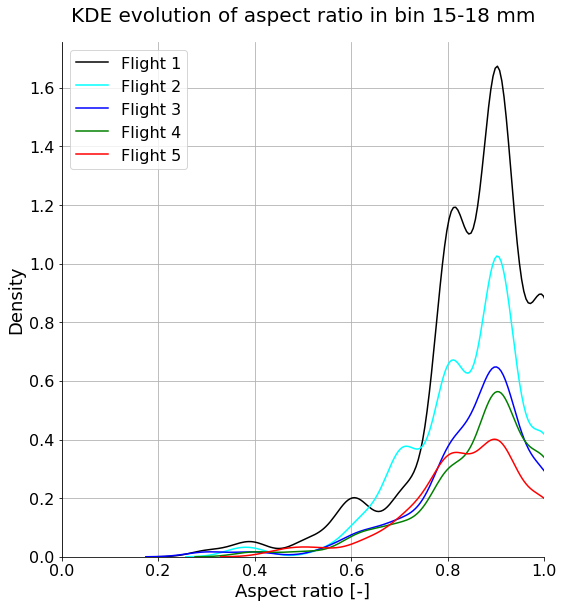

In [30]:
#Include initial bin-size dependence
#Look if hail the stone projections become more spherical with melting time
plot_dir = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/plots/melting/'
pal = ['black','cyan','blue','green','red']
pal.reverse()

xx = np.linspace(0,45,100)
lh_data = np.array(ar5[ind5[5][0]])[~np.isnan(ar5[ind5[5][0]])]
kde = stats.gaussian_kde(lh_data)
ax.plot(xx, kde(xx),color='blue',label='KDE')

#test = sns.displot(data=[ar5[ind5[5][0]], ar4[ind4[5][0]], ar3[ind3[5][0]], ar2[ind2[5][0]], ar1[ind1[5][0]]], kind="kde", bw_adjust=0.8, fill=False, legend=False, palette=pal,height=8,aspect=8/8)

plt.xlabel('Aspect ratio [-]')
plt.legend(labels=['Flight 1','Flight 2','Flight 3','Flight 4','Flight 5'],loc='upper left')
plt.title('KDE evolution of aspect ratio in bin 15-18 mm',fontsize=20,pad=20)
plt.xlim([0,1])
plt.grid()
plt.savefig(plot_dir+'KDE_aspect_ratio_bin5.png',dpi=400,bbox_inches='tight',facecolor='white')
#plt.show()

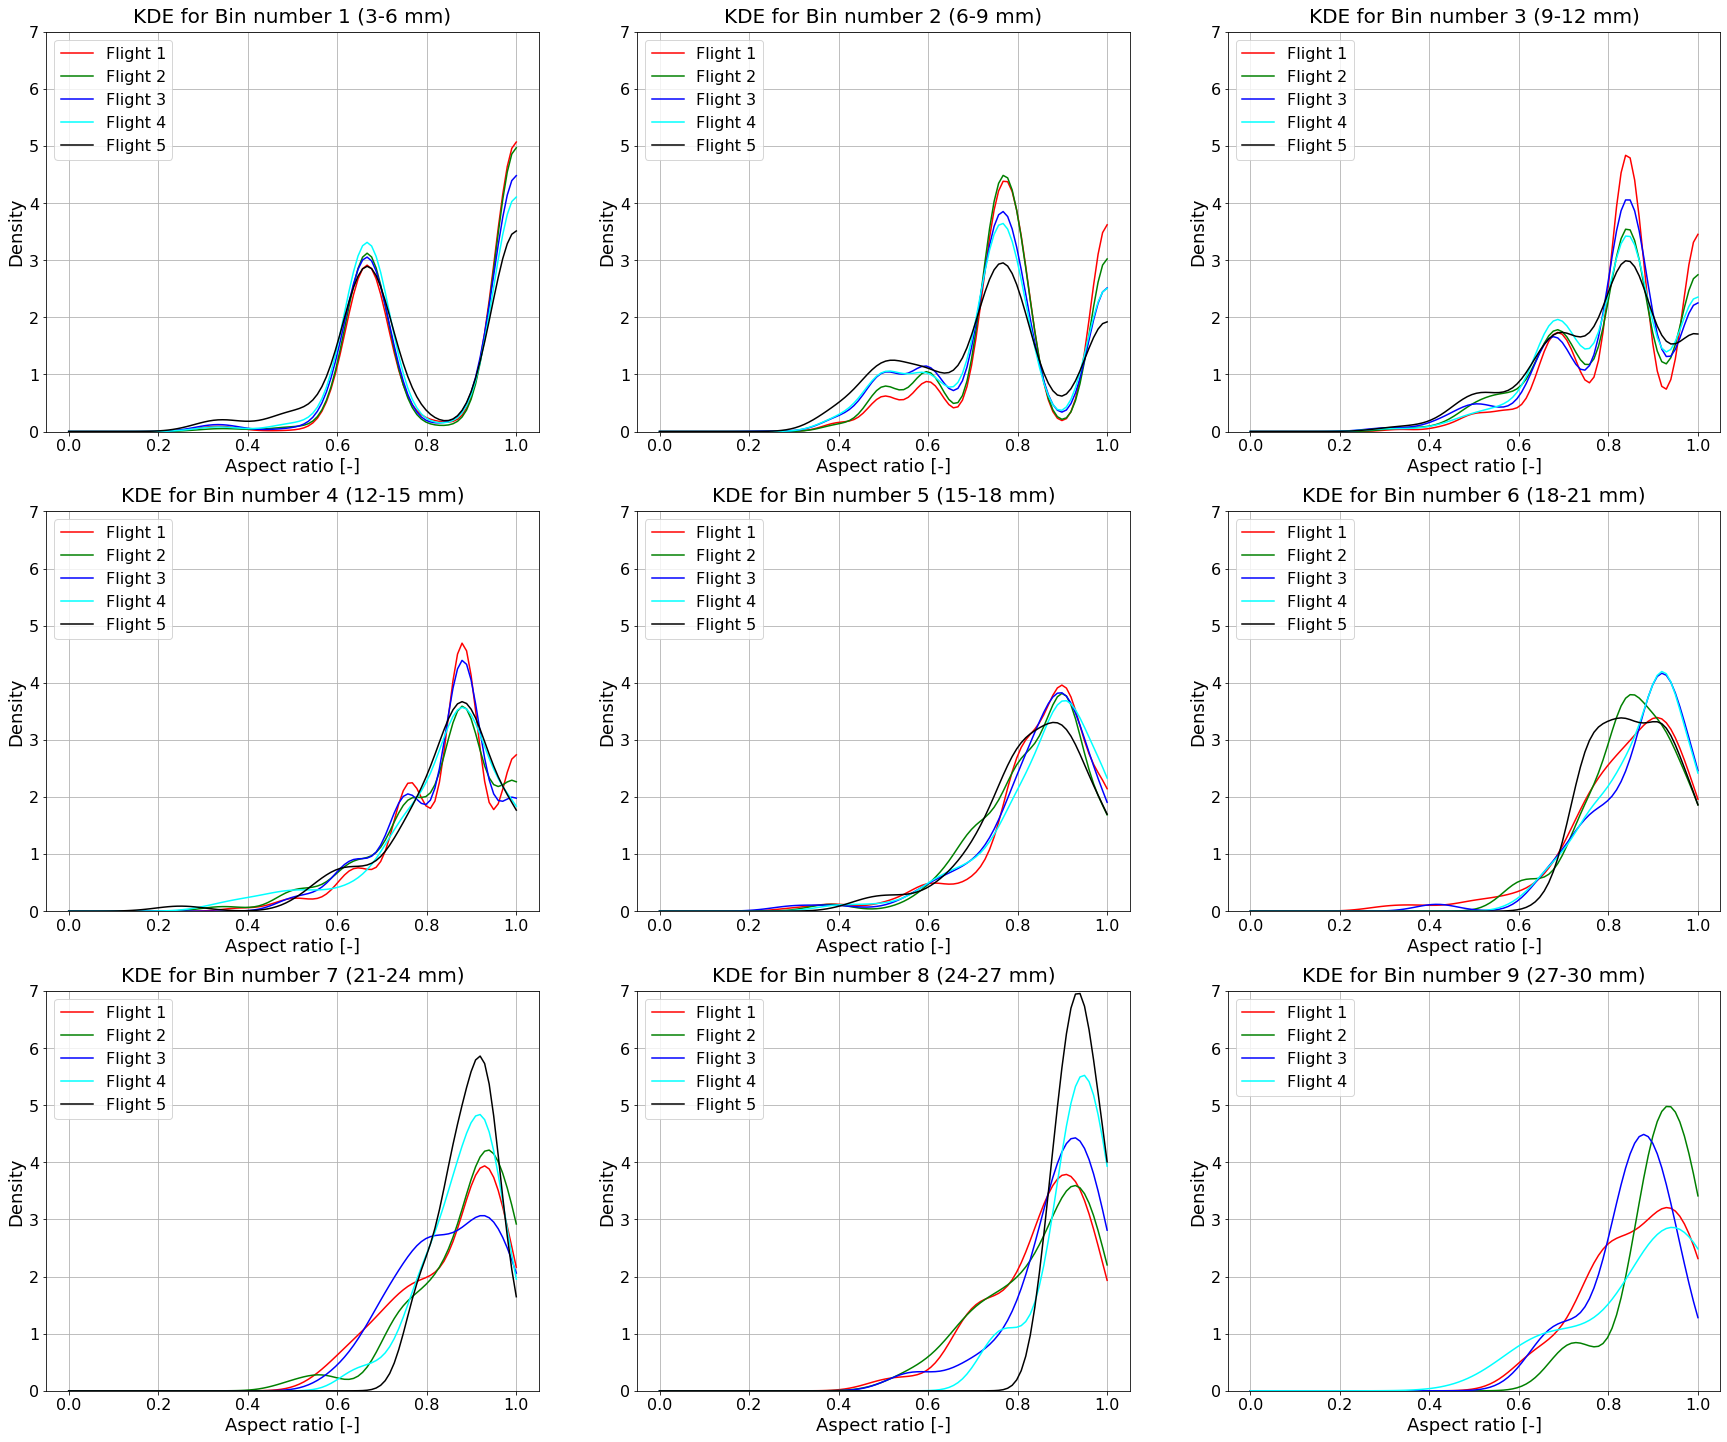

In [38]:
#Include initial bin-size dependence
#Look if hail the stone projections become more spherical with melting time
from scipy import stats
plot_dir = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/plots/melting/'
pal = ['black','cyan','blue','green','red']
flights=['Flight 1','Flight 2','Flight 3','Flight 4','Flight 5']
bintext = ['3-6 mm','6-9 mm','9-12 mm','12-15 mm','15-18 mm','18-21 mm','21-24 mm','24-27 mm','27-30 mm'] 
pal.reverse()

fig, ax = plt.subplots(3,3,figsize=[30,25])
ax = np.reshape(ax,9)

for k in range(1,10):
    
    for i in range(0,5):
        ax[k-1].grid()
        xx = np.linspace(0,1,100)
        lh_data = np.array(ar[i][indall[i][k][0]])[~np.isnan(ar[i][indall[i][k][0]])]
        try:
            kde = stats.gaussian_kde(lh_data)
        except:
            continue
        ax[k-1].plot(xx, kde(xx),color=pal[i],label=flights[i])
        ax[k-1].set_xlabel('Aspect ratio [-]')
        ax[k-1].set_ylabel('Density')
        ax[k-1].legend(loc='upper left')
        ax[k-1].set_title('KDE for Bin number '+str(k)+' ('+bintext[k-1]+')',fontsize=20,pad=10)
        ax[k-1].set_ylim([0,7])
        
plt.savefig('KDE_aspect_ratio_all_bins.png',dpi=400,bbox_inches='tight',facecolor='white')

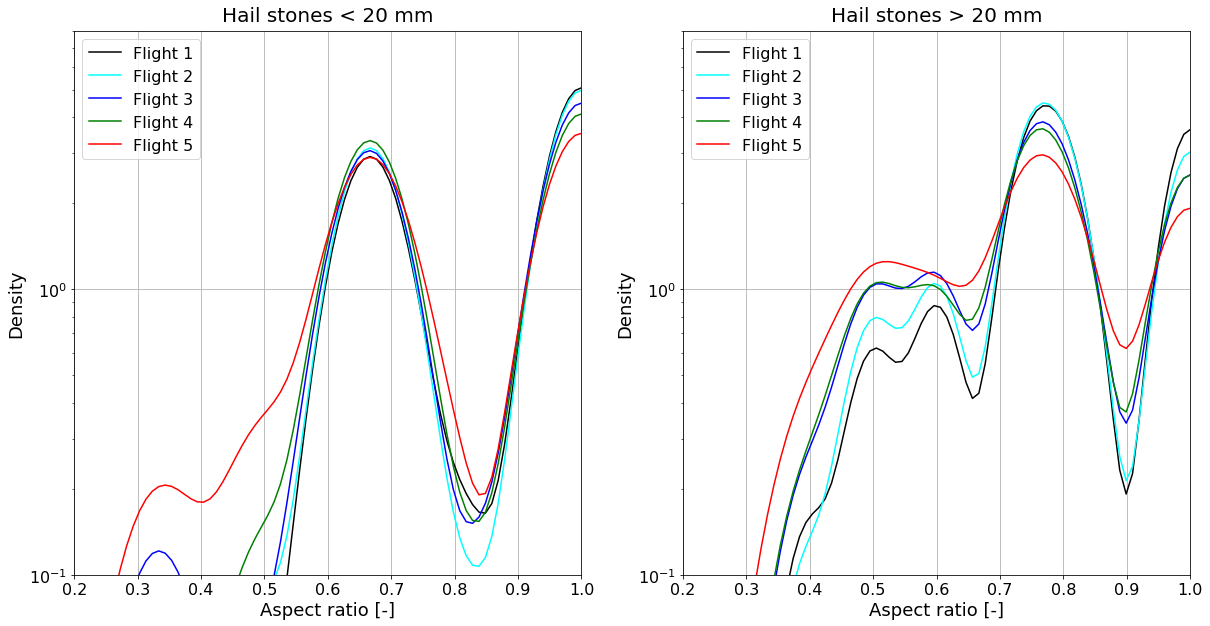

In [18]:
#Include initial bin-size dependence
#Look if hail the stone projections become more spherical with melting time
from scipy import stats
plot_dir = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/plots/melting/'
palc = ['black','cyan','blue','green','red']
flights=['Flight 1','Flight 2','Flight 3','Flight 4','Flight 5']
bintext = ['< 20 mm','> 20 mm']

fig, ax = plt.subplots(1,2,figsize=[20,10])
ax = np.reshape(ax,2)

for k in range(1,3):  
    for i in range(0,5):
        #print(i)
        #print(flights[i])
        #print(palc[i])
        ax[k-1].grid()
        xx = np.linspace(0,1,100)
        lh_data = np.array(ar[i][indall[i][k][0]])[~np.isnan(ar[i][indall[i][k][0]])]
        try:
            kde = stats.gaussian_kde(lh_data)
        except:
            continue
        ax[k-1].plot(xx, kde(xx),color=palc[i],label=flights[i])
        ax[k-1].set_xlabel('Aspect ratio [-]')
        ax[k-1].set_ylabel('Density')
        ax[k-1].legend(loc='upper left') 
        ax[k-1].set_title('Hail stones '+bintext[k-1],fontsize=20,pad=10)
        ax[k-1].set_ylim([0.1,8])
        ax[k-1].set_xlim([0.2,1])
        ax[k-1].set_yscale('log')
          
plt.savefig('KDE_aspect_ratio_2-bins.png',dpi=400,bbox_inches='tight',facecolor='white')

In [4]:
#get coordinates for all hail stones in all maps
x_r1 = dict_r1['hail_co'][0][:]
y_r1 = dict_r1['hail_co'][1][:]

x_r2 = dict_r2['hail_co'][0][:]
y_r2 = dict_r2['hail_co'][1][:]

x_r3 = dict_r3['hail_co'][0][:]
y_r3 = dict_r3['hail_co'][1][:]

x_r4 = dict_r4['hail_co'][0][:]
y_r4 = dict_r4['hail_co'][1][:]

x_r5 = dict_r5['hail_co'][0][:]
y_r5 = dict_r5['hail_co'][1][:]

In [5]:
cdict = {}
cdict['x0'] = x_r1
cdict['x1'] = x_r2
cdict['x2'] = x_r3
cdict['x3'] = x_r4
cdict['x4'] = x_r5

cdict['y0'] = y_r1
cdict['y1'] = y_r2
cdict['y2'] = y_r3
cdict['y3'] = y_r4
cdict['y4'] = y_r5

In [4]:
#Load all corresponding orthophotos
odm_p1 = '/home/martin/container/autofs/data/hail/odm/melting/ana/Kreis_r1_full.png'
odm_p2 = '/home/martin/container/autofs/data/hail/odm/melting/ana/Kreis_r2_full.png'
odm_p3 = '/home/martin/container/autofs/data/hail/odm/melting/ana/Kreis_r3_full.png'
odm_p4 = '/home/martin/container/autofs/data/hail/odm/melting/ana/Kreis_r4_full.png'
odm_p5 = '/home/martin/container/autofs/data/hail/odm/melting/ana/Kreis_r5_full.png'

In [24]:
img_rgb = cv2.imread(odm_p2)
template = np.asarray(dict_r1['img'][1234])[:,:,0:3]
w, h = np.shape(template)[0:2]
print(np.shape(template))
# Read the main image
img_rgb = cv2.imread(odm_p2)

In [101]:
#for i,x in enumerate(x_r1):
x = x_r2[147]
y = y_r2[147]
k=200
img_small = img_rgb[y-k:y+k, x-k:x+k,:]
print(np.shape(img_small))

# Convert it to grayscale
img_gray = cv2.cvtColor(img_small, cv2.COLOR_BGR2GRAY)
 
# Read the template
template = np.asarray(dict_r1['img'][147])[:,:,0:3]
template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
 
# Store width and height of template in w and h
w, h = np.shape(template_gray)[0:2]

# Perform match operations.
res = cv2.matchTemplate(img_gray, template_gray, cv2.TM_CCOEFF_NORMED)
 
# Specify a threshold
threshold = 0.23

# Store the coordinates of matched area in a numpy array
loc = np.where(res >= threshold)
print(loc)

(400, 400, 3)
(array([307, 308, 308]), array([73, 73, 74]))


In [88]:
img_small1 = img_rgb[y-k:y+k, x-k:x+k,:]
for pt in zip(*loc[::-1]):
    cv2.rectangle(img_small, pt, (pt[0] + w, pt[1] + h), (0, 255, 255), 2)
plt.imshow(img_small)

In [4]:
#Find biggest hail stone in soccer middle circle
print('Nu hail r1:', np.size(dict_r1['major_ma']))
print('Nu hail r2:', np.size(dict_r2['major_ma']))
print('Nu hail r3:', np.size(dict_r3['major_ma']))
print('Nu hail r4:', np.size(dict_r4['major_ma']))
print('Nu hail r5:', np.size(dict_r5['major_ma']))

#Find index of largest hail stone
ids = np.where(np.array(dict_r1['major_ma']) >= 33)[0][2]
print(ids)
item = (dict_r1['hail_co'][0][ids], dict_r1['hail_co'][1][ids])
print('item: ',item)

Nu hail r1: 3925
Nu hail r2: 3077
Nu hail r3: 2511
Nu hail r4: 1962
Nu hail r5: 1411
452
item:  (9505, 2042)


In [ ]:
from scipy.spatial import distance
import random
import shutil

#Find all hail stones in the bin widhts of 3mm
edges = np.linspace(27,33,3)
icount = 0

bin_path = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/melting/paper/'

for edge in edges:
    ids1 = np.where(np.logical_and([np.array(dict_r1['major_ma']) > edge], [np.array(dict_r1['major_ma']) <= edges[icount+1]]))[1]
    #get all x and y coordinates in map 1
    item = (dict_r1['hail_co'][0][ids1], dict_r1['hail_co'][1][ids1])
    item_size = np.size(item,1)
    xrand = random.choices(range(0, item_size), k=int(0.8*item_size))
    item_rand = (item[0][:], item[1][:])
    
    bin_dict = {}
    bin_str = str(int(edge))
    
    if icount == 2:
        break
    else:
        path = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/melting/r'
        gsd = 1.5

        ids2 = []
        ids3 = []
        ids4 = []
        ids5 = []

        for ii,xx in enumerate(item_rand[0]):
            yy = item_rand[1][ii]
            hail_co_item = (xx, yy)

            cp_path = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/melting/paper/bin-'+bin_str+'/'+str(ids1[ii])+'/'

            if not os.path.exists(cp_path):
                os.makedirs(cp_path)

            shutil.copyfile(path+'1/detection_ml/mask/hail_x'+str(xx)+'_y'+str(yy)+'_ma.png', cp_path+'r1_'+str(xx)+'_'+str(yy)+'.png')
            shutil.copyfile(path+'1/detection_ml/rgb/hail_x'+str(xx)+'_y'+str(yy)+'_rgb.png', cp_path+'rgb_r1_'+str(xx)+'_'+str(yy)+'.png')

            dist_list = []
            id_x = []
            id_y = []
            for i,x in enumerate(x_r2):
                    y = y_r2[i]
                    hail_co = (x, y)
                    dist = distance.euclidean(hail_co_item, hail_co) * gsd
                    if dist <= 1000:
                        dist_list.append(dist)
                        id_x.append(x)
                        id_y.append(y)

            id_min = np.where(np.array(dist_list) == np.min(dist_list))[0][0]

            x_tmp = id_x[id_min]
            y_tmp = id_y[id_min]
            id_tmp = np.where(np.logical_and([x_r2 == x_tmp],[y_r2 == y_tmp]))[1][0]
            ids2.append(id_tmp)

            #print(id_x[id_min])
            #print(id_y[id_min])
            shutil.copyfile(path+'2/detection_ml/mask/hail_x'+str(id_x[id_min])+'_y'+str(id_y[id_min])+'_ma.png', cp_path+'r2_'+str(id_x[id_min])+'_'+str(id_y[id_min])+'.png')
            shutil.copyfile(path+'2/detection_ml/rgb/hail_x'+str(id_x[id_min])+'_y'+str(id_y[id_min])+'_rgb.png', cp_path+'rgb_r2_'+str(id_x[id_min])+'_'+str(id_y[id_min])+'.png')
            #print('---')

            dist_list = []
            id_x = []
            id_y = []
            for i,x in enumerate(x_r3):
                    y = y_r3[i]
                    hail_co = (x, y)
                    dist = distance.euclidean(hail_co_item, hail_co) * gsd
                    if dist <= 1000:
                        dist_list.append(dist)
                        id_x.append(x)
                        id_y.append(y)

            id_min = np.where(np.array(dist_list) == np.min(dist_list))[0][0]

            x_tmp = id_x[id_min]
            y_tmp = id_y[id_min]
            id_tmp = np.where(np.logical_and([x_r3 == x_tmp], [y_r3 == y_tmp]))[1][0]
            ids3.append(id_tmp)

            #print(id_x[id_min])
            #print(id_y[id_min])
            shutil.copyfile(path+'3/detection_ml/mask/hail_x'+str(id_x[id_min])+'_y'+str(id_y[id_min])+'_ma.png', cp_path+'r3_'+str(id_x[id_min])+'_'+str(id_y[id_min])+'.png')
            shutil.copyfile(path+'3/detection_ml/rgb/hail_x'+str(id_x[id_min])+'_y'+str(id_y[id_min])+'_rgb.png', cp_path+'rgb_r3_'+str(id_x[id_min])+'_'+str(id_y[id_min])+'.png')

            #print('---')

            dist_list = []
            id_x = []
            id_y = []
            for i,x in enumerate(x_r4):
                    y = y_r4[i]
                    hail_co = (x, y)
                    dist = distance.euclidean(hail_co_item, hail_co) * gsd
                    if dist <= 1000:
                        dist_list.append(dist)
                        id_x.append(x)
                        id_y.append(y)

            id_min = np.where(np.array(dist_list) == np.min(dist_list))[0][0]

            x_tmp = id_x[id_min]
            y_tmp = id_y[id_min]
            id_tmp = np.where(np.logical_and([x_r4 == x_tmp],[y_r4 == y_tmp]))[1][0]
            ids4.append(id_tmp)

            #print(id_x[id_min])
            #print(id_y[id_min])
            shutil.copyfile(path+'4/detection_ml/mask/hail_x'+str(id_x[id_min])+'_y'+str(id_y[id_min])+'_ma.png', cp_path+'r4_'+str(id_x[id_min])+'_'+str(id_y[id_min])+'.png')
            shutil.copyfile(path+'4/detection_ml/rgb/hail_x'+str(id_x[id_min])+'_y'+str(id_y[id_min])+'_rgb.png', cp_path+'rgb_r4_'+str(id_x[id_min])+'_'+str(id_y[id_min])+'.png')

            #print('---')

            dist_list = []
            id_x = []
            id_y = []
            for i,x in enumerate(x_r5):
                    y = y_r5[i]
                    hail_co = (x, y)
                    dist = distance.euclidean(hail_co_item, hail_co) * gsd
                    if dist <= 1000:
                        dist_list.append(dist)
                        id_x.append(x)
                        id_y.append(y)

            id_min = np.where(np.array(dist_list) == np.min(dist_list))[0][0]

            x_tmp = id_x[id_min]
            y_tmp = id_y[id_min]
            id_tmp = np.where(np.logical_and([x_r5 == x_tmp], [y_r5 == y_tmp]))[1][0]
            ids5.append(id_tmp)

            #print(id_x[id_min])
            #print(id_y[id_min])
            shutil.copyfile(path+'5/detection_ml/mask/hail_x'+str(id_x[id_min])+'_y'+str(id_y[id_min])+'_ma.png', cp_path+'r5_'+str(id_x[id_min])+'_'+str(id_y[id_min])+'.png')
            shutil.copyfile(path+'5/detection_ml/rgb/hail_x'+str(id_x[id_min])+'_y'+str(id_y[id_min])+'_rgb.png', cp_path+'rgb_r5_'+str(id_x[id_min])+'_'+str(id_y[id_min])+'.png')             

            #print('---')
        
        icount = icount + 1
        
    ids2 = np.array(ids2)
    ids3 = np.array(ids3)
    ids4 = np.array(ids4)
    ids5 = np.array(ids5)

    #Major and minor sizes for all 5 runs for hs > 20mm
    major1 = np.array(dict_r1['major_ma'])[ids1]
    major2 = np.array(dict_r2['major_ma'])[ids2]
    major3 = np.array(dict_r3['major_ma'])[ids3]
    major4 = np.array(dict_r4['major_ma'])[ids4]
    major5 = np.array(dict_r5['major_ma'])[ids5]

    minor1 = np.array(dict_r1['minor_ma'])[ids1]
    minor2 = np.array(dict_r2['minor_ma'])[ids2]
    minor3 = np.array(dict_r3['minor_ma'])[ids3]
    minor4 = np.array(dict_r4['minor_ma'])[ids4]
    minor5 = np.array(dict_r5['minor_ma'])[ids5]
    
    bin_dict['ids1'] = np.array(ids1)
    bin_dict['ids2'] = ids2
    bin_dict['ids3'] = ids3
    bin_dict['ids4'] = ids4
    bin_dict['ids5'] = ids5
    
    bin_dict['major1'] = major1
    bin_dict['major2'] = major2
    bin_dict['major3'] = major3
    bin_dict['major4'] = major4
    bin_dict['major5'] = major5
    
    bin_dict['minor1'] = minor1
    bin_dict['minor2'] = minor2
    bin_dict['minor3'] = minor3
    bin_dict['minor4'] = minor4
    bin_dict['minor5'] = minor5
    
    with open(bin_path+'bin-'+bin_str+'.pkl','wb') as f:
        pk.dump(bin_dict,f)

In [4]:
#Investigate 48 hail stones from different bins and calculate melting rate for 1119s (1 vs. 5 map)
import re
edges = np.linspace(9,30,8)

major1 = []
major2 = []
major3 = []
major4 = []
major5 = []

for i,edge in enumerate(edges):
    bin_str = str(int(edge))
    
    with open('/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/melting/paper/bin-'+bin_str+'.pkl','rb') as f:
        bin_dict = pk.load(f)
    cp_path = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/melting/paper/bin-'+bin_str+'/good/'
    sub_folders = [name for name in os.listdir(cp_path) if os.path.isdir(os.path.join(cp_path, name))]
    sub_folders.sort()
    
    for fold in sub_folders:
        names = [os.path.basename(x) for x in glob.glob(cp_path+fold+'/rgb*')]
        names.sort()
        #print(names)
        for i,na in enumerate(names):
            no = re.findall(r'\d+', na)
            x = int(no[1])
            y = int(no[2])
            if i == 0:
                id_tmp = np.where(np.logical_and([x_r1 == x],[y_r1 == y]))[1][0]
                major1.append(np.array(dict_r1['major_ma'])[id_tmp])
            elif i == 1:
                id_tmp = np.where(np.logical_and([x_r2 == x],[y_r2 == y]))[1][0]
                major2.append(np.array(dict_r2['major_ma'])[id_tmp])
            elif i == 2:
                id_tmp = np.where(np.logical_and([x_r3 == x],[y_r3 == y]))[1][0]
                major3.append(np.array(dict_r3['major_ma'])[id_tmp])
            elif i == 3:
                id_tmp = np.where(np.logical_and([x_r4 == x],[y_r4 == y]))[1][0]
                major4.append(np.array(dict_r4['major_ma'])[id_tmp])
            elif i == 4:
                id_tmp = np.where(np.logical_and([x_r5 == x],[y_r5 == y]))[1][0]
                major5.append(np.array(dict_r5['major_ma'])[id_tmp])
                

In [6]:
m1 = np.reshape(np.array(major1),[8,6])
m2 = np.reshape(np.array(major2),[8,6])
m3 = np.reshape(np.array(major3),[8,6])
m4 = np.reshape(np.array(major4),[8,6])
m5 = np.reshape(np.array(major5),[8,6])

In [7]:
#Mean melting rate per bin size based on 6 hail stones per bin
diff_mean = np.mean(m1-m5, 1)
diff = m1-m5
mrate = np.round((diff_mean/1119)*60,2)

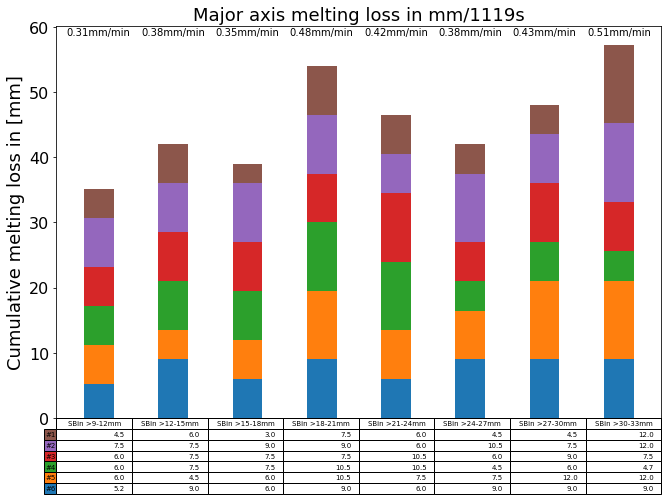

In [220]:
import numpy as np
import matplotlib.pyplot as plt

plot_dir = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/plots/melting/'
columns = ('SBin >9-12mm', 'SBin >12-15mm', 'SBin >15-18mm','SBin >18-21mm', 'SBin >21-24mm', 'SBin >24-27mm', 'SBin >27-30mm','SBin >30-33mm')
rows = ('#1','#2','#3','#4','#5','#6')

values = np.arange(0, 15, 32)
value_increment = 0.5

# Get some pastel shades for the colors
colors = plt.cm.tab10(np.linspace(0, 0.5, len(rows)))
n_rows = np.size(diff,1)

index = np.arange(len(columns)) + 0.3
bar_width = 0.4

# Initialize the vertical-offset for the stacked bar chart.
y_offset = np.zeros(len(columns))
fig = plt.subplots(figsize=[12,8])
# Plot bars and create text labels for the table
cell_text = []
for row in range(n_rows):
    bars = plt.bar(index, diff[:,row], bar_width, bottom=y_offset, color=colors[row])
    y_offset = y_offset + diff[:,row]
    cell_text.append(['%1.1f' % (x) for x in diff[:,row]])
# Reverse colors and text labels to display the last value at the top.
colors = colors[::-1]
cell_text.reverse()

for n,rect in enumerate(bars):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, 60, str(mrate[n])+'mm/min', ha='center', va='top',fontsize=10)

# Add a table at the bottom of the axes
the_table = plt.table(cellText=cell_text,
                      rowLabels=rows,
                      rowColours=colors,
                      colLabels=columns,
                      loc='bottom')

# Adjust layout to make room for the table:
plt.subplots_adjust(left=0.2, bottom=0.2)

plt.ylabel('Cumulative melting loss in [mm]')
#plt.yticks(values * value_increment, ['%d' % val for val in values])
plt.xticks([])
plt.title('Major axis melting loss in mm/1119s')

plt.savefig(plot_dir+'melting_loss_example_stat.png',bbox_inches='tight',facecolor='white',dpi=300)

In [8]:
from itertools import tee

def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

mrate_final = np.hstack([np.array([0.31,0.31]), mrate])

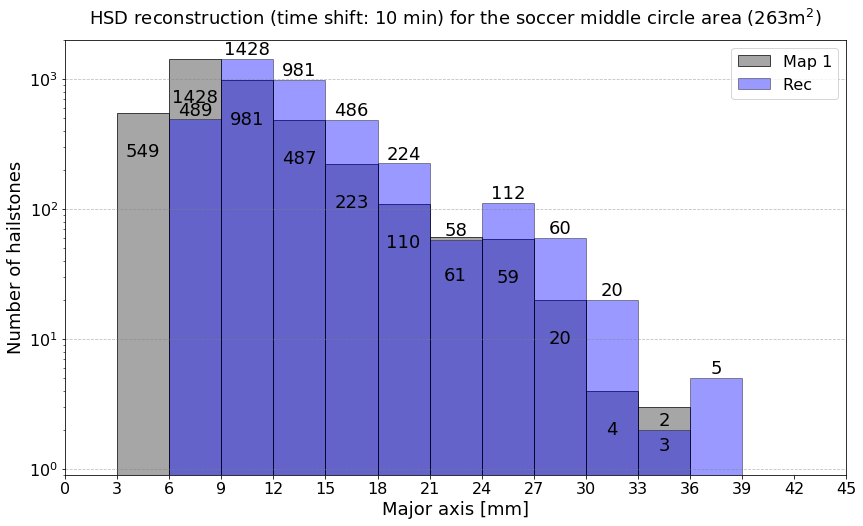

In [21]:
plot_dir = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/plots/melting/'
numBins = 18
backtime = 10

fig, ax = plt.subplots(figsize=(14,8))
x = np.asarray(dict_r1['major_ma'])
counts, edges, bars = ax.hist(dict_r1['major_ma'], numBins, range=[3,45+12], color=['grey'], alpha=0.7, edgecolor='black', density=False,label='Map 1')

nbin = 0
alt_data = []
for left, right in pairwise(edges):
    indices = np.where((x > left) & (x <= right))
    alt_data.append(x[indices] + (backtime*mrate_final[nbin]))
    nbin=nbin+1
    if nbin == 10:
        break
        
alt_data10 = np.concatenate(alt_data)
#generate 2 hail stones per second to reconstruct first bin
#Loss rate per second
loss_hail_rate = (np.size(dict_r1['major_ma']) - np.size(dict_r5['major_ma'])) / 1119
new_hail = np.zeros(backtime*60*int(loss_hail_rate))+ mrate_final[0]*backtime
alt_data10_new = np.hstack([alt_data10,new_hail])

counts_rec, edges_rec, bars_rec = ax.hist(alt_data10,numBins,range=[3,45+12],color=['blue'],alpha=0.4, edgecolor='black',label='Rec ')

plt.bar_label(bars_rec,padding=0)
plt.bar_label(bars,label_type='center')
plt.title('HSD reconstruction (time shift: 10 min) for the soccer middle circle area (263m$^{2}$)',fontsize=18,pad=15)
plt.ylim([0.9,2000])
plt.xlim([0,45])
plt.yscale('log')
plt.grid(axis='y',color='grey',linestyle='--',alpha=0.5)
plt.xticks(np.linspace(0,39+6,14+2))
plt.ylabel('Number of hailstones')
plt.xlabel('Major axis [mm]')
plt.legend(loc='upper right')
plt.savefig(plot_dir+'HSD_reconstruction_log.png',dpi=300,bbox_inches='tight',facecolor='white')
#plt.show()

In [5]:
#Plot series of melting hail stones as masks and rgb
#Rearrange 2 individual figures into one single plot for paper
fig = plt.figure(figsize=(20, 7))
# setting values to rows and column variables
rows = 2
columns = 5
#ids = 452
ids = 42

plot_dir = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/melting/paper/'
path = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/melting/paper/'+str(ids)+'/'

rgb_files = sorted( filter( os.path.isfile,
                        glob.glob(path + 'rgb*.png') ) )

mask_files = sorted( filter( os.path.isfile,
                        glob.glob(path + 'r?_*.png') ) )

# reading images
count = 1
for file in rgb_files:
    img = cv2.imread(file)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    fig.add_subplot(rows, columns, count)
    plt.imshow(img_rgb)
    plt.axis('off')
    count = count+1

count = 6
for file in mask_files:
    img = cv2.imread(file)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    fig.add_subplot(rows, columns, count)
    plt.imshow(img_rgb)
    plt.axis('off')
    count = count + 1

# using padding
fig.tight_layout(pad=1.0)
    
## Adds a subplot at the 2nd position
#fig.add_subplot(rows, columns, 2)
#plt.imshow(image1_rgb)
#plt.axis('off')

#fig.suptitle('Kernel density estimation (KDE) of hail size distributions during melting process')
#fig.subplots_adjust(top=1.2)
plt.show()
#plt.savefig(plot_dir+str(ids)+'_melting_overview.png',dpi=300,bbox_inches='tight',facecolor='white')


<Figure size 1440x504 with 0 Axes>

In [6]:
tstring = ['$0\,$s','$307\,$s','$580\,$s','$848\,$s','$1119\,$s','$0\,$s','$307\,$s','$580\,$s','$848\,$s','$1119\,$s'] 

In [8]:
tstring[8]

'848s'

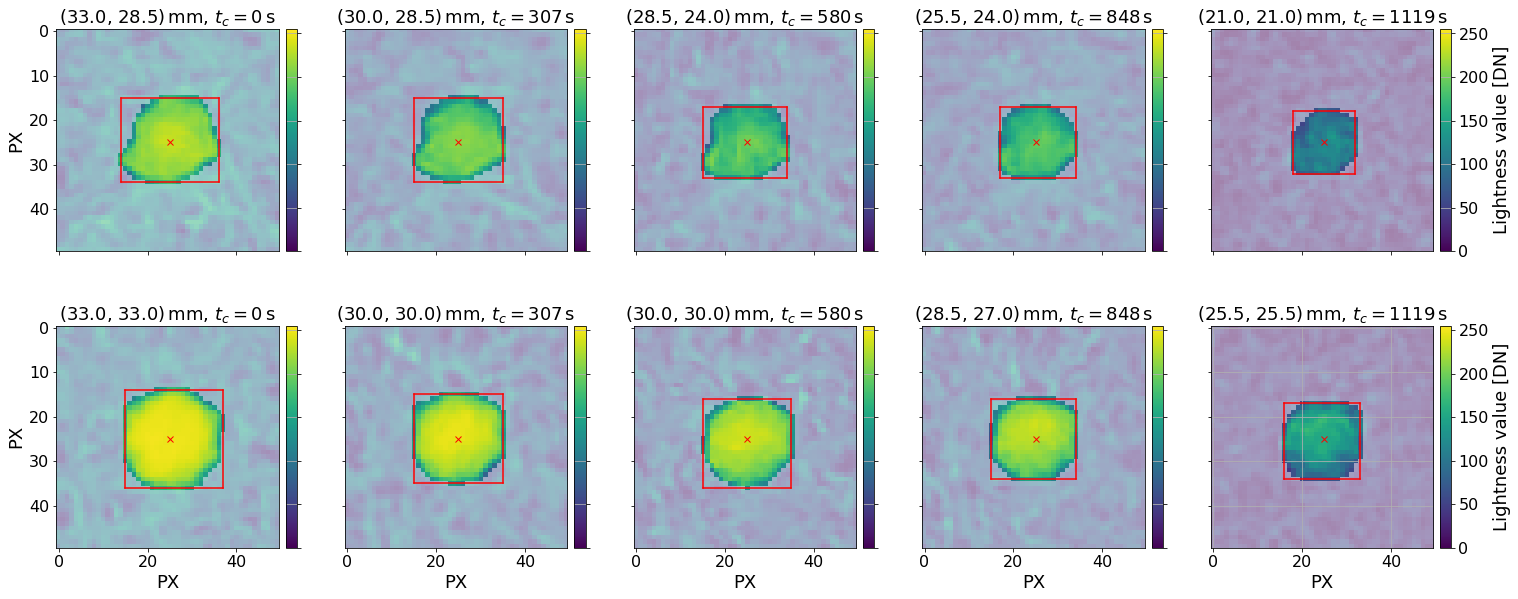

In [20]:
from bbox.min_bounding_rect import minBoundingRect
plot_dir = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/plots/melting/'

fig, ax = plt.subplots(2,5,figsize=[25,10])
ax = np.reshape(ax,10)

gsd = 1.5

xc = [6484, 6475, 6425, 6474, 6468, 5946, 5948, 5905, 5948, 5943]
yc = [573, 639, 604, 648, 630, 2079, 2128, 2106, 2134, 2122]
k=25
x0 = 25
y0 = 25
          
it = [0,1,2,3,4,0,1,2,3,4]

tstring = ['$0\,$s','$307\,$s','$580\,$s','$848\,$s','$1119\,$s','$0\,$s','$307\,$s','$580\,$s','$848\,$s','$1119\,$s'] 

for i,x in enumerate(xc):

    y = yc[i]
    id_tmp = np.where(np.logical_and([cdict['x'+str(it[i])] == x],[cdict['y'+str(it[i])] == y]))[1][0]

    #Create ghost mask as big as zoom mask eg (50,50)
    empty_mask = np.zeros([2*k, 2*k], dtype=int)
    img_mask = empty_mask

    mask = ndict[str(it[i])]['img_mask_sect'][id_tmp]

    img_mask[0:np.size(mask,0), 0:np.size(mask,1)] = mask

    s = np.argwhere(mask == 1)
    (rot_angle_ma, area_ma, width_ma, height_ma, center_point_ma, box_ma) = minBoundingRect(np.fliplr(s))
    major_size_ma = np.max([width_ma,height_ma]) * gsd
    minor_size_ma = np.min([width_ma,height_ma]) * gsd

    img_hls = cv2.cvtColor(ndict[str(it[i])]['img'][id_tmp], cv2.COLOR_RGB2HLS)

    ax[i].plot(x0,y0,marker='x', color='red')
    plt.grid()

    mask_tmp = img_mask[0:np.size(img_hls,0), 0:np.size(img_hls,1)]

    img_hls_masked = np.ma.masked_array(img_hls[:,:,1], mask=mask_tmp)
    img_hls_masked_bg = np.ma.masked_array(img_hls[:,:,1], mask=np.where((mask_tmp==0)|(mask_tmp==1), mask_tmp^1, mask_tmp))

    ax[i].imshow(img_hls_masked, cmap='viridis', interpolation='none', alpha=0.5, norm=None, vmin=0, vmax=255)
    pos = ax[i].imshow(img_hls_masked_bg, cmap='viridis', interpolation='none', norm=None, vmin=0, vmax=255)

    #ax[i].set_yticks([])

    if i == 0 or i == 5:
        ax[i].set_ylabel('PX')
    else:
        ax[i].set_yticklabels([])

    #if i == 4:
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="5%", pad=0.1)

    if i == 4 or i == 9:
        cbar = fig.colorbar(pos, ax=ax[i], cax=cax, label = 'Lightness value [DN]')
    else:
        cbar = fig.colorbar(pos, ax=ax[i], cax=cax, label = '')
        cbar.set_ticklabels([])
        
    #plot bounding box:
    ax[i].plot([box_ma[0][0],box_ma[1][0]],[box_ma[0][1],box_ma[1][1]],color='red')
    ax[i].plot([box_ma[1][0],box_ma[2][0]],[box_ma[1][1],box_ma[2][1]],color='red')
    ax[i].plot([box_ma[2][0],box_ma[3][0]],[box_ma[2][1],box_ma[3][1]],color='red')
    ax[i].plot([box_ma[3][0],box_ma[0][0]],[box_ma[3][1],box_ma[0][1]],color='red')
    ax[i].set_title('('+str(np.round(major_size_ma,2))+', '+str(np.round(minor_size_ma,2))+')$\,$mm, '+'$t_c =$'+tstring[i])

    if i > 4:
        ax[i].set_xlabel('PX')
    else:
        ax[i].set_xlabel('')
        ax[i].set_xticklabels([])
   

plt.savefig(plot_dir+'hail_n2_melting_REV.png',dpi=400,bbox_inches='tight',facecolor='white')

In [8]:
np.reshape(ax,15)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

In [22]:
mask_files

['/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/melting/paper/41/r1_6484_573.png',
 '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/melting/paper/41/r2_6475_639.png',
 '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/melting/paper/41/r3_6425_604.png',
 '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/melting/paper/41/r4_6474_648.png',
 '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/melting/paper/41/r5_6468_630.png']

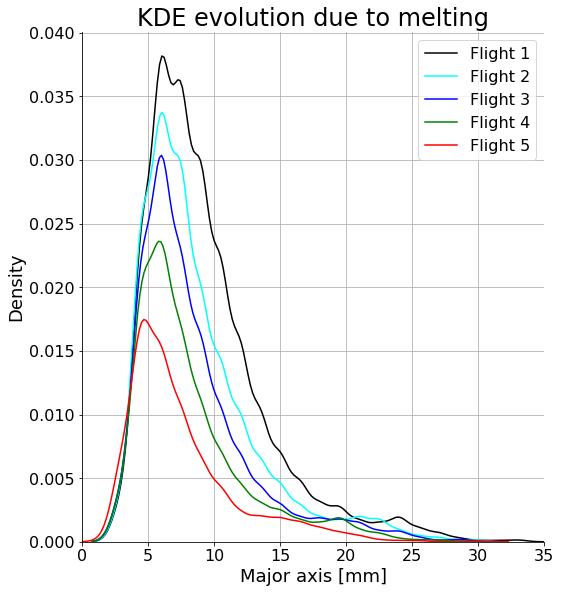

In [21]:
plot_dir = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/plots/melting/'
pal = ['black','cyan','blue','green','red']
pal.reverse()
test = sns.displot(data=[dict_r5['major_ma'], dict_r4['major_ma'], dict_r3['major_ma'], dict_r2['major_ma'], dict_r1['major_ma']], kind="kde", bw_adjust=0.8, fill=False, legend=False, palette=pal,height=8,aspect=8/8)

plt.xlabel('Major axis [mm]')
plt.legend(labels=['Flight 1','Flight 2','Flight 3','Flight 4','Flight 5'])
plt.title('KDE evolution due to melting',fontsize=24)
plt.xlim([0,35])
plt.grid()
plt.savefig(plot_dir+'KDE_evolution_melting_REV.png',dpi=400,bbox_inches='tight',facecolor='white')
#plt.show()

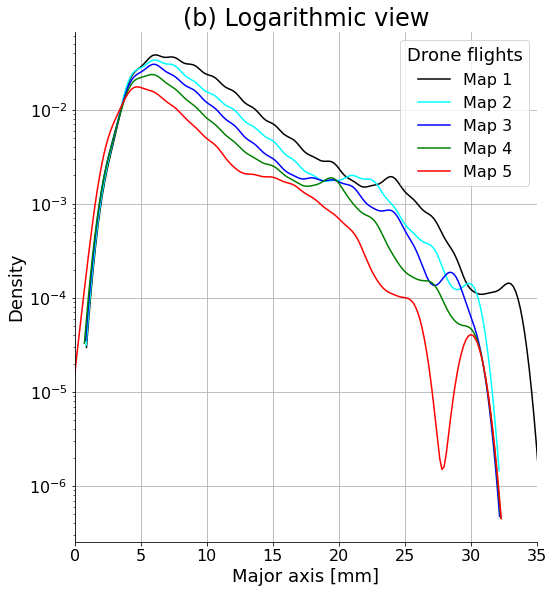

In [16]:
plot_dir = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/plots/melting/'
pal = ['black','cyan','blue','green','red']
pal.reverse()
sns.displot(data=[dict_r5['major_ma'], dict_r4['major_ma'], dict_r3['major_ma'], dict_r2['major_ma'], dict_r1['major_ma']], kind="kde", bw_adjust=0.8, fill=False, legend=False, palette=pal,height=8,aspect=8/8)

plt.xlabel('Major axis [mm]')
plt.legend(title='Drone flights', labels=['Flight 1','Flight 1','Flight 1','Flight 1','Flight 1'])
plt.title('(b) Logarithmic view',fontsize=24)
plt.yscale('log')
plt.xlim([0,35])
plt.grid()
plt.savefig(plot_dir+'KDE_evolution_melting_log.png',dpi=300,bbox_inches='tight',facecolor='white')
#plt.show()

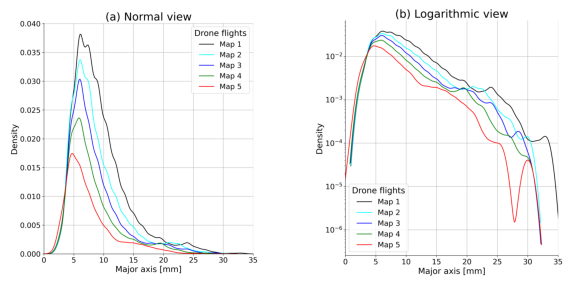

In [3]:
plot_dir = '/home/martin/container/hail/detectron2/products/hparam_tuning/run-3/plots/melting/'
#Rearrange 2 individual figures into one single plot for paper
fig = plt.figure(figsize=(10, 7))
# setting values to rows and column variables
rows = 1
columns = 2
  
# reading images
Image1 = cv2.imread(plot_dir+'KDE_evolution_melting_log.png')
image1_rgb = cv2.cvtColor(Image1, cv2.COLOR_BGR2RGB)

Image2 = cv2.imread(plot_dir+'KDE_evolution_melting.png')
image2_rgb = cv2.cvtColor(Image2, cv2.COLOR_BGR2RGB)

fig.add_subplot(rows, columns, 1)
plt.imshow(image2_rgb)
plt.axis('off')

# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
plt.imshow(image1_rgb)
plt.axis('off')

#fig.suptitle('Kernel density estimation (KDE) of hail size distributions during melting process',fontsize=12)
#fig.subplots_adjust(top=1.2)

plt.savefig(plot_dir+'KDE_melting_2new_rev.png',dpi=400,bbox_inches='tight',facecolor='white')

Experimental investigations with sklearn toolbox

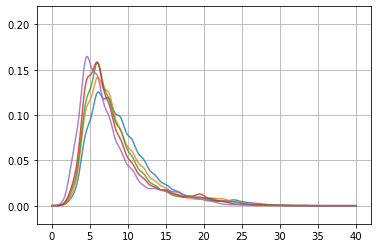

In [78]:
from sklearn.neighbors import KernelDensity
x_d = np.linspace(0,40,1000)

data1 = np.asarray(dict_r1['major_ma'])
data2 = np.asarray(dict_r2['major_ma'])
data3 = np.asarray(dict_r3['major_ma'])
data4 = np.asarray(dict_r4['major_ma'])
data5 = np.asarray(dict_r5['major_ma'])

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=0.7, kernel='gaussian')
k1 = kde.fit(data1.reshape(-1,1))

kde = KernelDensity(bandwidth=0.7, kernel='gaussian')
k2 = kde.fit(data2.reshape(-1,1))

kde = KernelDensity(bandwidth=0.7, kernel='gaussian')
k3 = kde.fit(data3.reshape(-1,1))

kde = KernelDensity(bandwidth=0.7, kernel='gaussian')
k4 = kde.fit(data4.reshape(-1,1))

kde = KernelDensity(bandwidth=0.7, kernel='gaussian')
k5 = kde.fit(data5.reshape(-1,1))

l1 = k1.score_samples(x_d[:, None])
l2 = k2.score_samples(x_d[:, None])
l3 = k3.score_samples(x_d[:, None])
l4 = k4.score_samples(x_d[:, None])
l5 = k5.score_samples(x_d[:, None])

plt.plot(x_d, np.exp(l1), alpha=0.8)
plt.plot(x_d, np.exp(l2), alpha=0.8)
plt.plot(x_d, np.exp(l3), alpha=0.8)
plt.plot(x_d, np.exp(l4), alpha=0.8)
plt.plot(x_d, np.exp(l5), alpha=0.8)

#plt.plot(data, np.full_like(data, -0.01), '|k', markeredgewidth=1)
plt.ylim(-0.02, 0.22)
plt.grid()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

bandwidths = 10 ** np.linspace(-1, 1, 100)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=KFold(n_splits=10))
grid.fit(data.reshape(-1,1))